In [129]:
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import json
from tqdm import tqdm

In [12]:
# load model pre-trained model on imagenet
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

x = torch.randn(1, 3, 224, 224)
y = model(x)
print(y.shape)

torch.Size([1, 1000])


In [17]:
import ast

with open('class_to_sysnet.json', 'r') as f:
    file_content = f.read()
    sysnet_mapping = ast.literal_eval(file_content)

In [22]:
sysnet_to_idx_mapping = {}
idx_to_class_mapping = {}
sysnet_to_class_mapping = {}

for key, value_map in sysnet_mapping.items():
    class_idx = key
    sysnet = "".join(value_map['id'].split("-"))    
    class_name = value_map['label'].split(",")[0]
    
    sysnet_to_idx_mapping[sysnet] = class_idx
    idx_to_class_mapping[class_idx] = class_name
    sysnet_to_class_mapping[sysnet] = class_name
    
    
print(f"len(sysnet_to_idx_mapping): {len(sysnet_to_idx_mapping.keys())}")
print(f"len(idx_to_class_mapping): {len(idx_to_class_mapping.keys())}")
print(f"len(sysnet_to_class_mapping): {len(sysnet_to_class_mapping.keys())}")

len(sysnet_to_idx_mapping): 999
len(idx_to_class_mapping): 1000
len(sysnet_to_class_mapping): 999


In [23]:
# define dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

data_dir = "imagenet-mini/val"
dataset = datasets.ImageFolder(root = data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [253]:
# show a sample image
def denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = np.array(mean)
    std = np.array(std)
    
    img = img * std[:, None, None] + mean[:, None, None]  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to valid range [0, 1]
    return img

def visualize_imagenet_image(img, label=None, save_path = None):
    
    class_name = ""
    
    if label is not None:
        class_idx = label.item()
        class_name = idx_to_class_mapping[class_idx]
    
    img = img.cpu().numpy()
    
    
    
    # print(img.shape)
    img = img.reshape(img.shape[1:])
    img = denormalize_image(img)
    img = img.transpose(1, 2, 0)
    plt.axis("off")
    
    if class_name != "":
        plt.title(class_name)
    
    plt.imshow(img)
    
    if save_path is not None:
        plt.savefig(save_path)

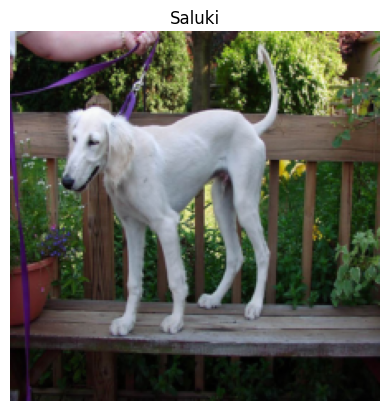

In [36]:
x, y = next(iter(dataloader))

visualize_imagenet_image(x, label=y)

# Saliency Maps

Goal: Optimize the image with respect to the class

From: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034)

In [158]:
def visualize_saliency_map(image, saliency_map, label):
    """
    Visualize the image and its saliency map side by side.
    
    Args:
        image (torch.Tensor): Tensor of shape (1, 3, 224, 224) containing pixel values.
        saliency_map (torch.Tensor): Tensor of shape (1, 1, 224, 224) containing gradient values.
        label (str): Class name corresponding to the input image.
    """
    # Detach and convert tensors to numpy
    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Shape: (224, 224, 3)
    saliency_map_np = saliency_map.squeeze().cpu().numpy()     # Shape: (224, 224)
    
    # Normalize image to [0, 1] for display
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    # Normalize saliency map to [0, 1]
    saliency_map_np = (saliency_map_np - saliency_map_np.min()) / (saliency_map_np.max() - saliency_map_np.min())
    
    # Plot the image and saliency map side by side
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title('Original Image')
    
    # Saliency Map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map_np, cmap='gray')
    plt.axis('off')
    plt.title(f"Saliency Map for '{label}'")
    
    # Show the plots
    plt.tight_layout()
    plt.show()
    



def compute_saliency_map(model, x, y, mode="sum"):
    """
    computes saliency map of RGB image (x) for a given model and class label (y)
    
    supported modes for aggregating over RGB channels are:
        
        sum: sum over RGB channels
        max: max over RGB channels
        mean: avg over RGB channels
    """    
    model.eval()
    
    device = next(model.parameters()).device
    x = x.to(device) # port the input to the specified device
    
    
    x.requires_grad = True
    output = model(x) # shape: (B, 1000)
    
    # compute gradients

    loss = F.cross_entropy(output, y)
    loss.backward()
    
    if mode == "sum":
        
        saliency_map = x.grad.abs().sum(dim=1)
    elif mode == "max":
        saliency_map, _ = x.grad.abs().max(dim=1)        
    elif mode == "mean":
        saliency_map = x.grad.abs().mean(dim=1)
        
    saliency_map = saliency_map.detach()
        
    return saliency_map

In [159]:
x, y = next(iter(dataloader))
saliency_map = compute_saliency_map(model, x, y, mode="sum")
label = idx_to_class_mapping[y.item()]

visualize_saliency_map(x.detach(), saliency_map, label)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

# Class Visualization

Goal: Create an image that maximally activates a specific class

From: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034)

In [240]:
import torch.optim as optim


def compute_class_model_visualization(model, class_idx, image_tensor = None, lambda_reg=0.1, learning_rate=1e-2, num_iter=1000, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], visualize_every=1000):
    device = next(model.parameters()).device
    model.eval()
    
    training_log = {
        'num_iter': [],
        'classification_score': [],
        'regularization_loss': [],
        'total_loss': []
    }
    
    if image_tensor is None:
        # initialize optimize image as gaussian noise
        image = torch.zeros(1, 3, 224, 224, device=device)
        image.requires_grad = True
        
    else:
        image = image_tensor.clone()
        image.requires_grad = True
    
    optimizer = optim.Adam([image], lr=learning_rate)
    
    
    
    for i in tqdm(range(num_iter)):
        # forward pass
        output = model(image) # 1, 1000
        class_score = -output[0, class_idx]        
        regularization_loss = lambda_reg * torch.linalg.norm(image.view(-1)) ** 2
        total_loss = class_score + regularization_loss
        
        total_loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            image = image.clamp_(-1, 1)
        
        # with torch.no_grad():
        #     image.data = image.data + image.grad * learning_rate
        #     image = torch.clamp(image, -1, 1)
        
        # image.grad.zero_()
        # image.requires_grad = True    
        
        training_log['num_iter'].append(i)
        training_log['classification_score'].append(class_score.item())
        training_log['regularization_loss'].append(regularization_loss.item())
        training_log['total_loss'].append(total_loss.item())
        
        
        
        
        if i % visualize_every == 0:
            visualize_imagenet_image(image.detach())
            plt.show()
            plt.plot(training_log['classification_score'])
            plt.show()
            plt.plot(training_log['regularization_loss'])
            plt.show()
    
    return image.detach(), training_log

  0%|          | 0/15000 [00:00<?, ?it/s]

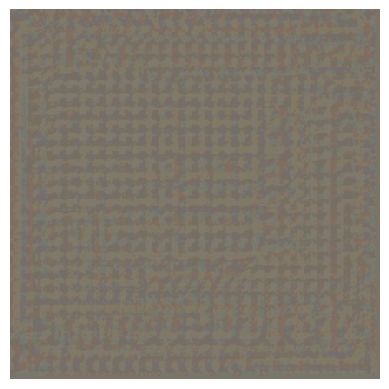

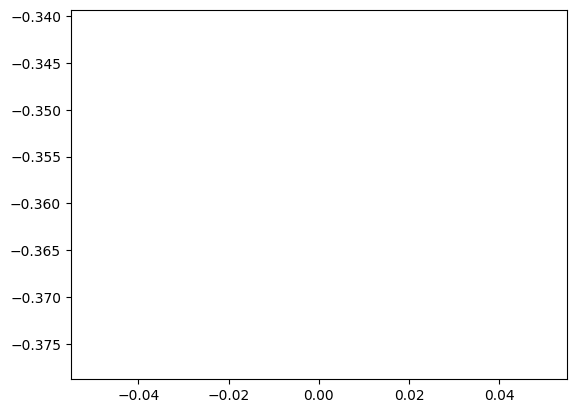

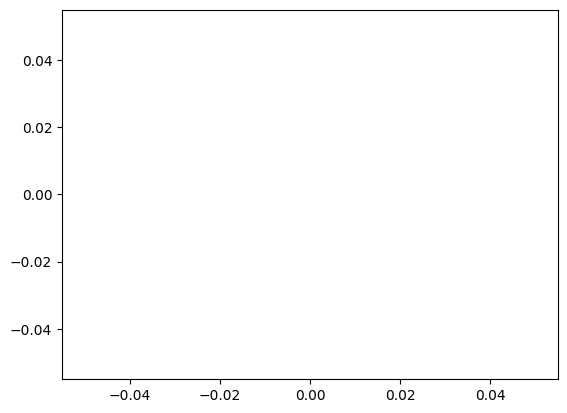

  7%|▋         | 998/15000 [00:16<03:52, 60.33it/s]

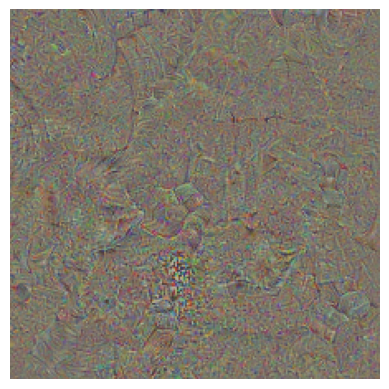

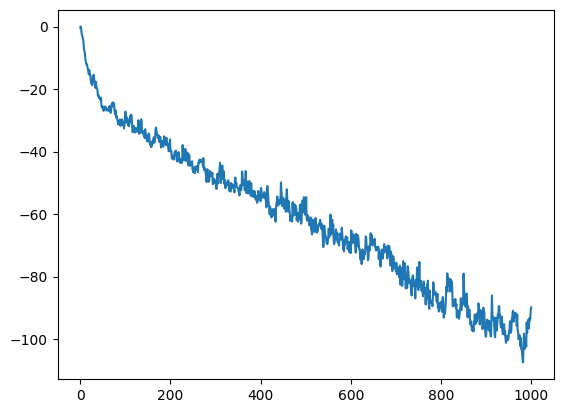

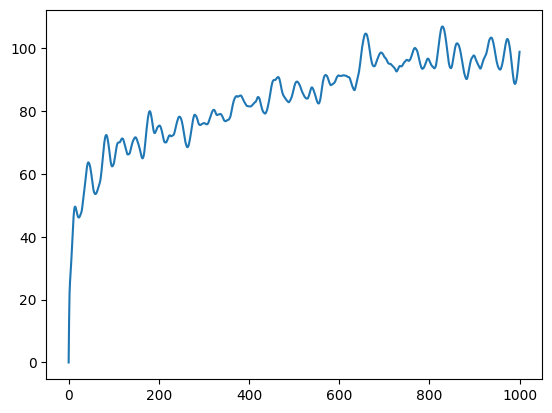

 13%|█▎        | 1996/15000 [00:33<03:36, 60.20it/s]

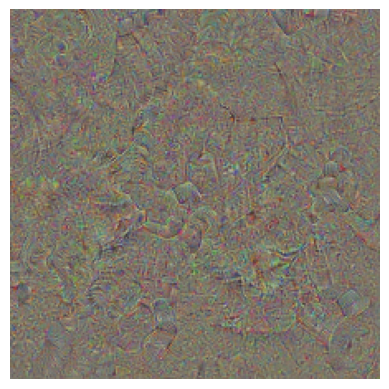

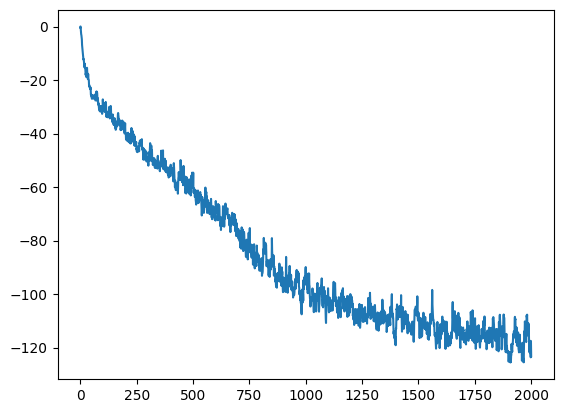

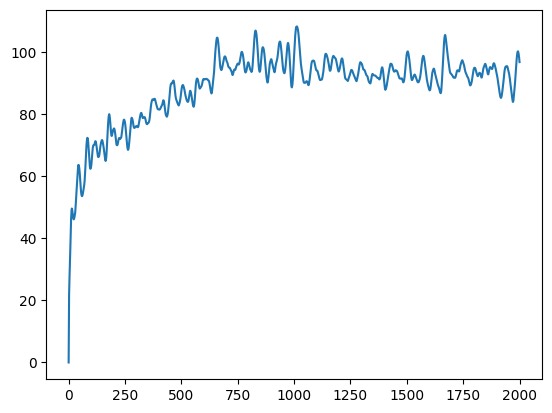

 20%|██        | 3000/15000 [00:50<03:21, 59.65it/s]

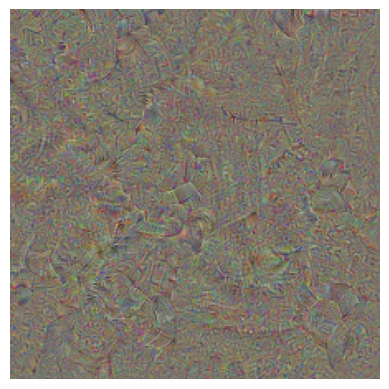

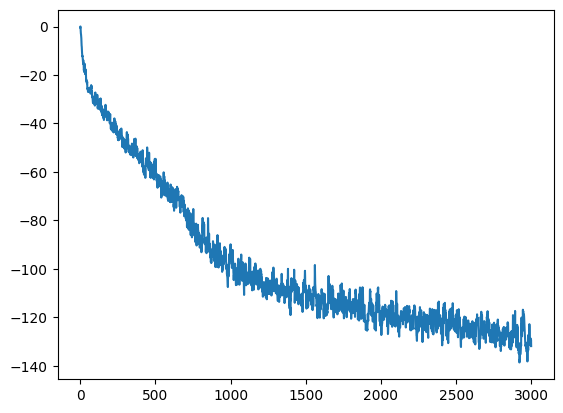

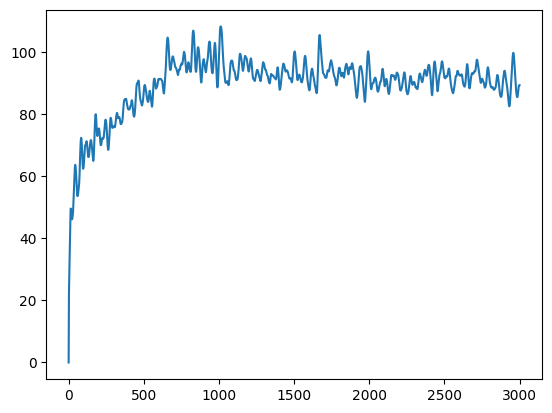

 27%|██▋       | 3994/15000 [01:07<03:02, 60.25it/s]

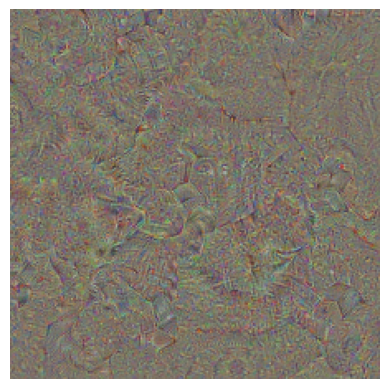

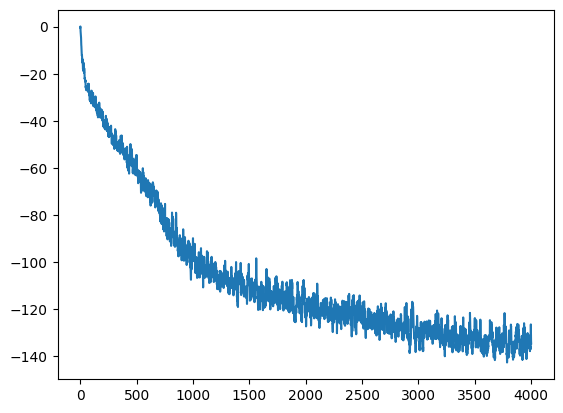

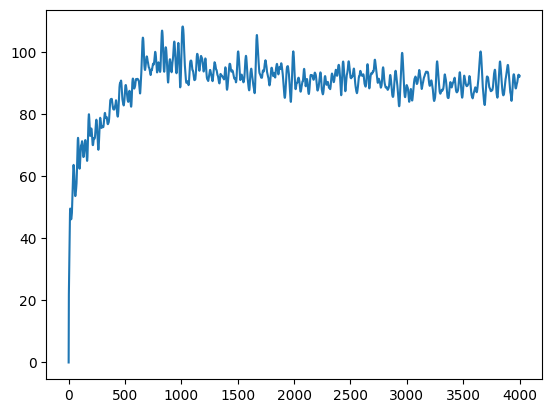

 33%|███▎      | 5000/15000 [01:24<02:45, 60.34it/s]

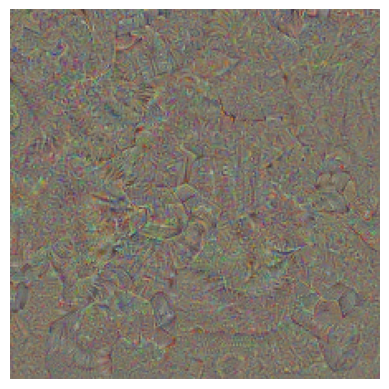

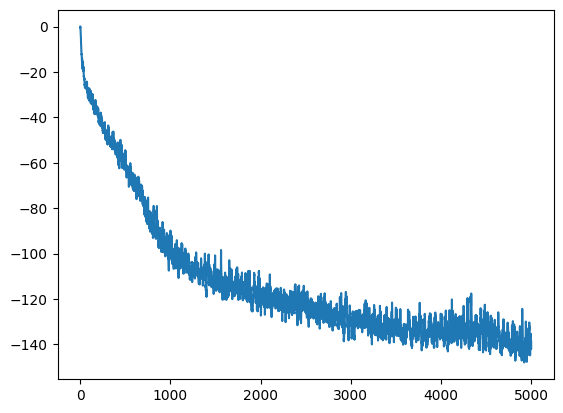

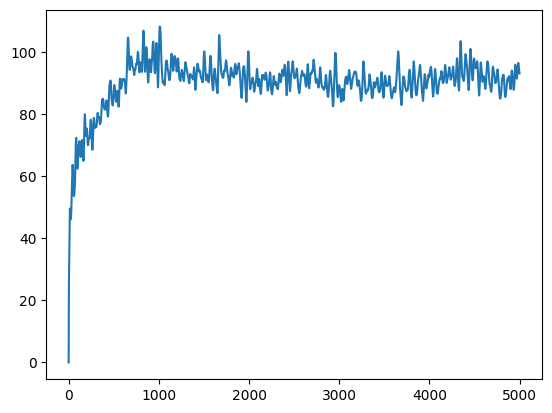

 33%|███▎      | 5007/15000 [01:24<04:41, 35.54it/s]

In [ ]:
new_image_tensor, training_log = compute_class_model_visualization(model, 543, image_tensor = None, lambda_reg=9e-3, learning_rate=0.1, num_iter=15000)

In [254]:
old_image_tensor = new_image_tensor.clone()

  0%|          | 0/15000 [00:00<?, ?it/s]

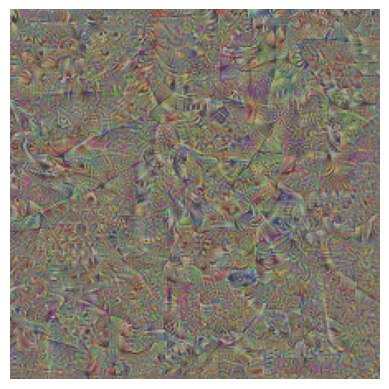

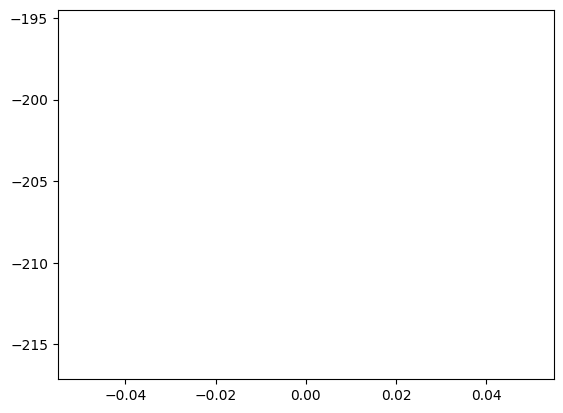

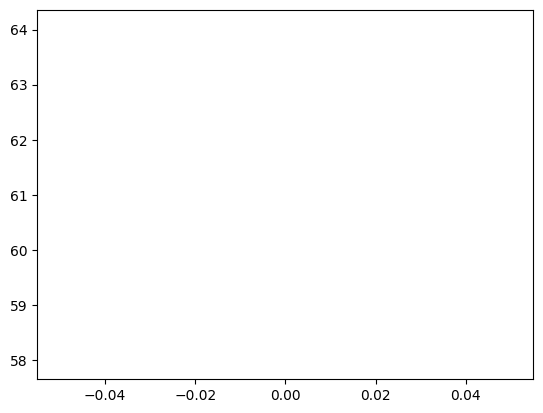

  7%|▋         | 995/15000 [00:16<03:52, 60.20it/s]

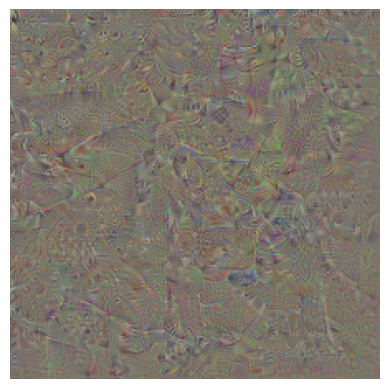

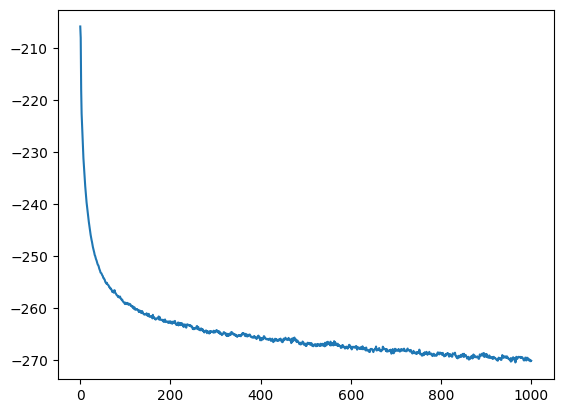

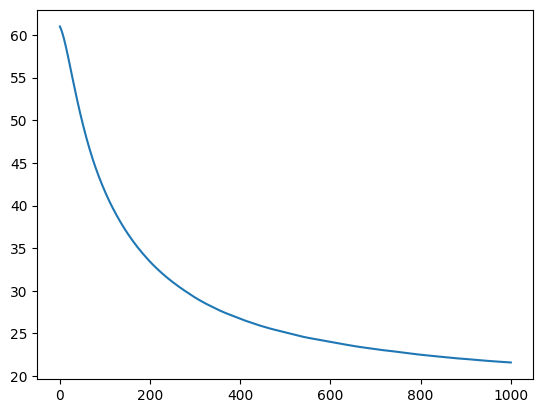

 13%|█▎        | 2000/15000 [00:33<03:35, 60.28it/s]

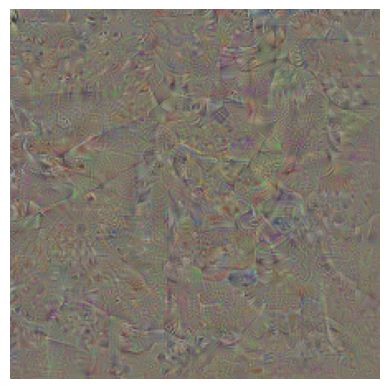

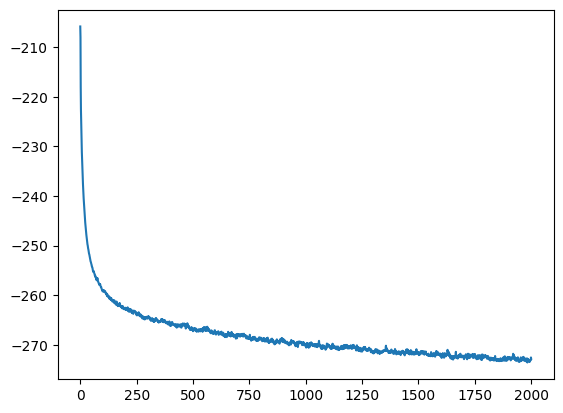

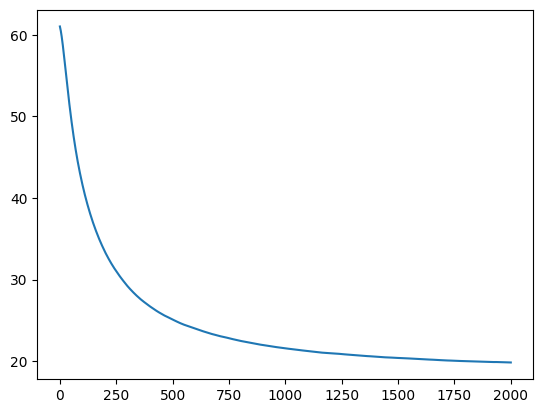

 20%|█▉        | 2999/15000 [00:50<03:19, 60.10it/s]

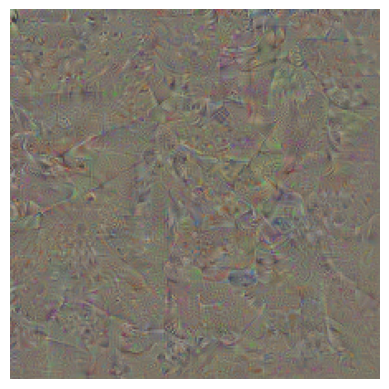

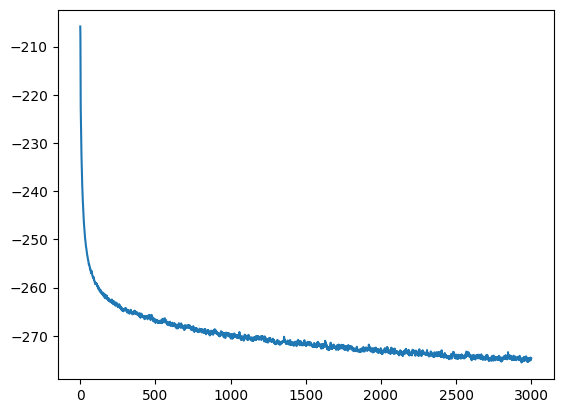

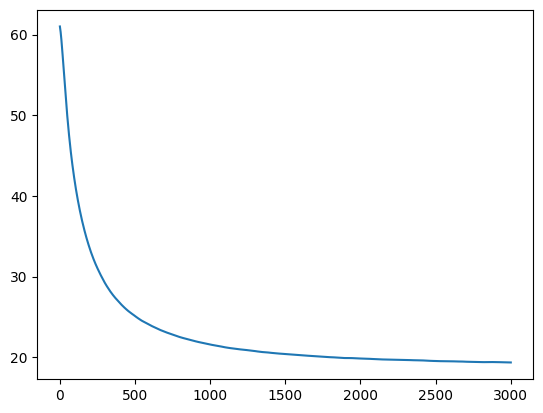

 27%|██▋       | 4000/15000 [01:07<03:02, 60.38it/s]

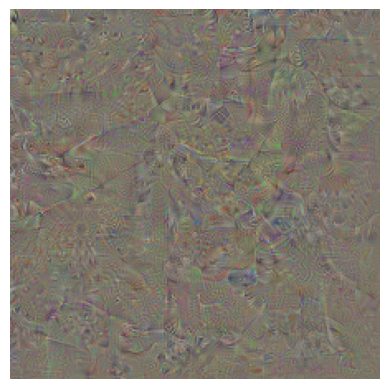

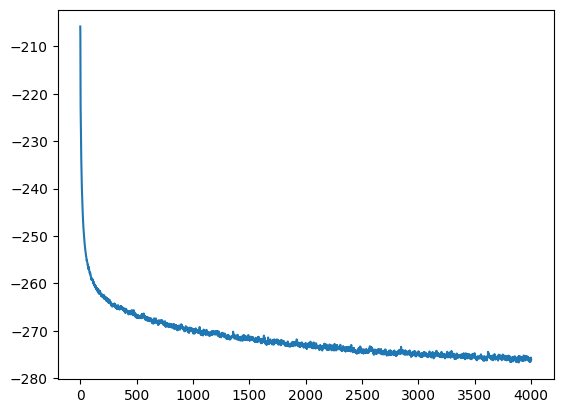

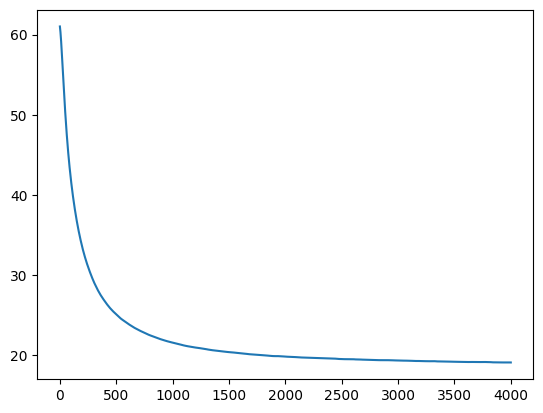

 33%|███▎      | 4996/15000 [01:24<02:46, 60.25it/s]

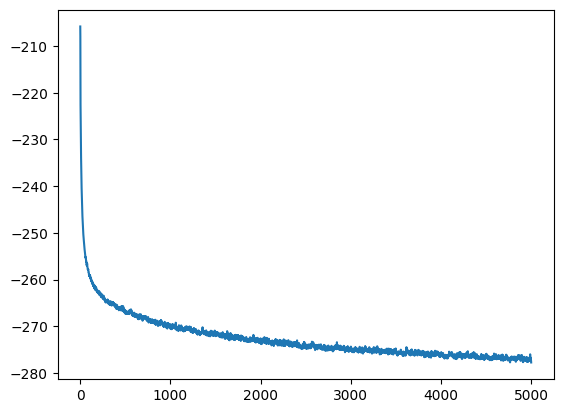

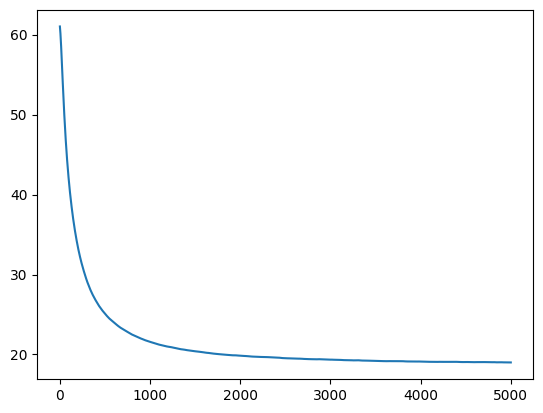

 40%|███▉      | 5994/15000 [01:41<02:29, 60.09it/s]

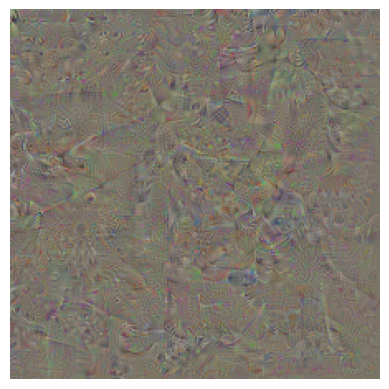

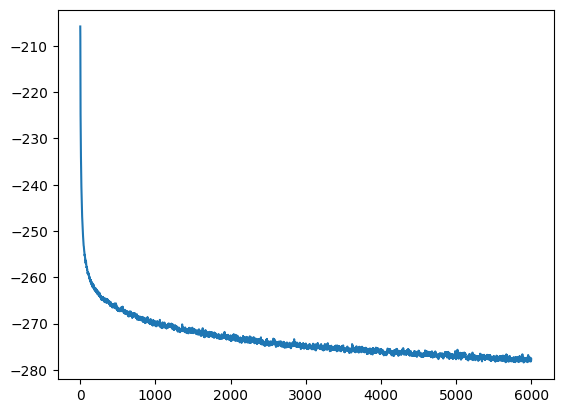

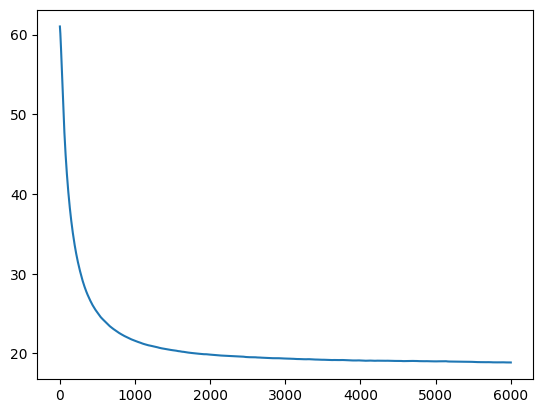

 47%|████▋     | 6997/15000 [01:58<02:12, 60.39it/s]

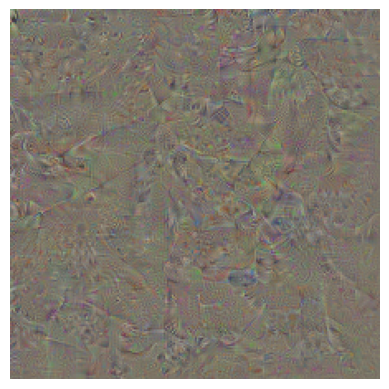

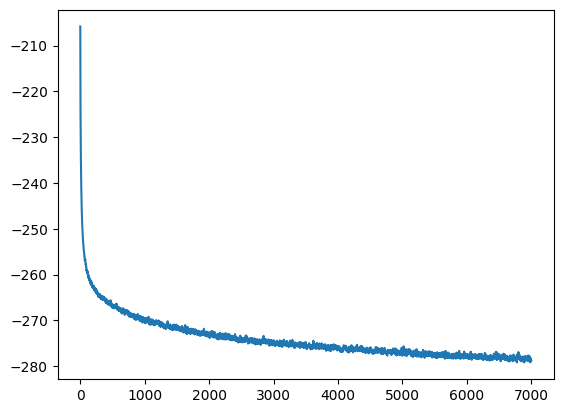

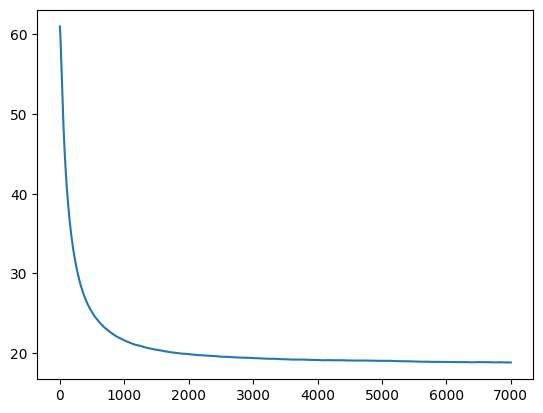

 53%|█████▎    | 8000/15000 [02:15<01:57, 59.70it/s]

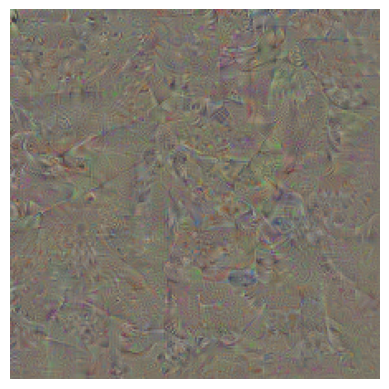

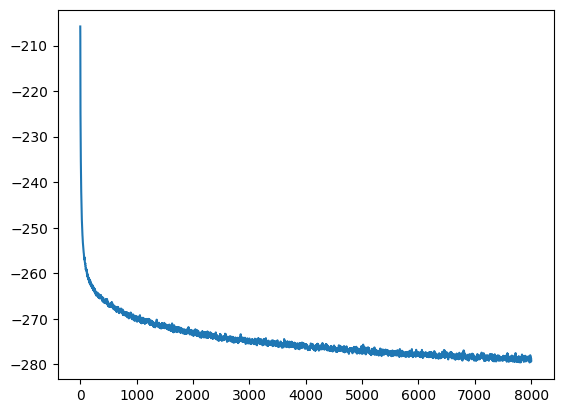

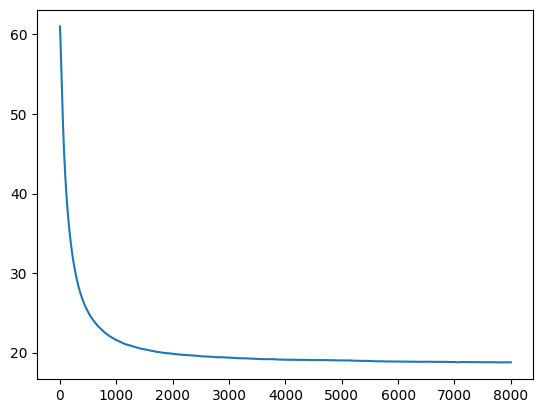

 60%|█████▉    | 8999/15000 [02:32<01:40, 59.88it/s]

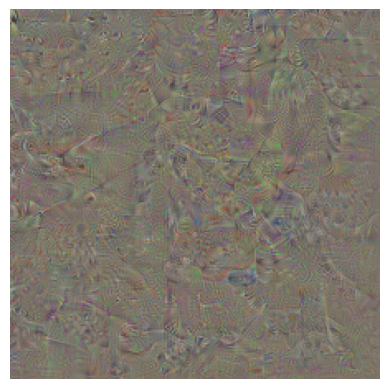

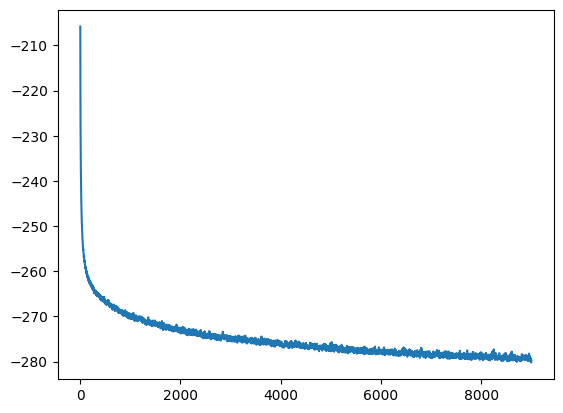

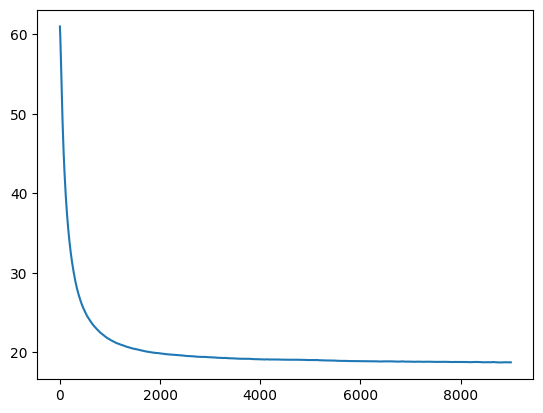

 67%|██████▋   | 9998/15000 [02:49<01:24, 59.52it/s]

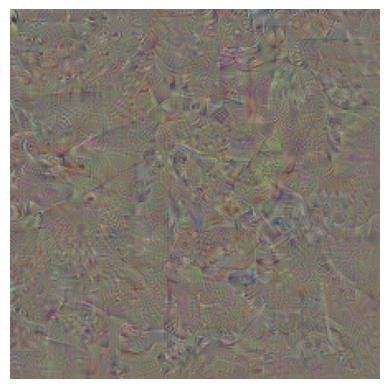

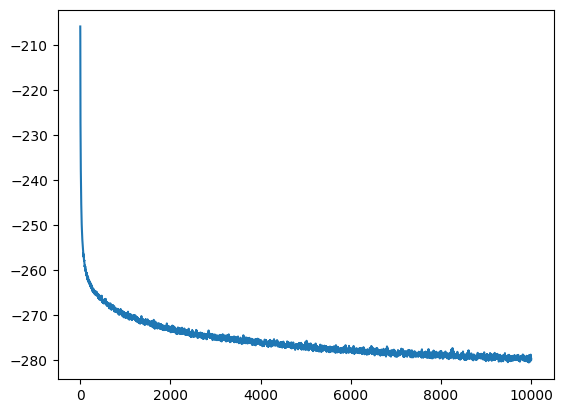

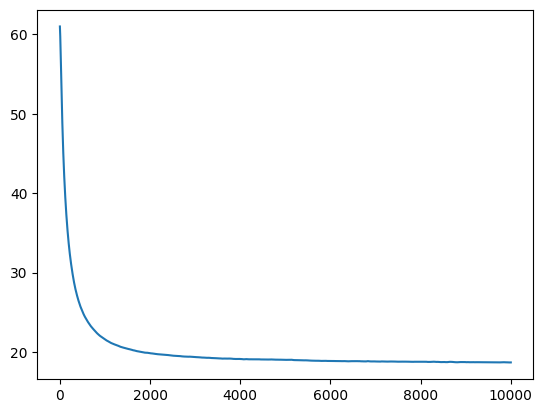

 69%|██████▉   | 10328/15000 [02:55<01:19, 58.99it/s]


KeyboardInterrupt: 

In [255]:
new_image_tensor, training_log = compute_class_model_visualization(model, 251, image_tensor = old_image_tensor.clone(), lambda_reg=3e-3, learning_rate=1e-2, num_iter=15000)

In [231]:
model(old_image_tensor)[0, 251]

tensor(221.4894, device='cuda:0', grad_fn=<SelectBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


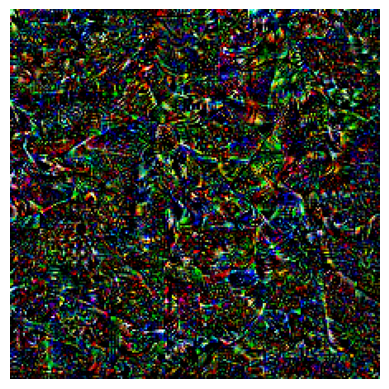

In [252]:
visualize_imagenet_image(new_image_tensor, denormalize=False)

# Grad-CAM

Goal: Comptue the gradients of a feature map with respect to the final class probability and compute their average. Then overlay this on the original image.

In [ ]:
class HookManager:
    def __init__(self, model):
        self.model = model
        self.forward_hooks = []
        self.backward_hooks = []
        
        self.module_names = []
        self.module_to_shape_map = {}
        
        self.initialize_hook_manager()
        
        
    
    def initialize_hook_manager(self):
        """
        Lists all modules and their output shapes after a forward pass.

        Args:
            input_tensor (torch.Tensor): Input tensor to pass through the model.

        Returns:
            List[Tuple[str, torch.Size]]: A list of tuples containing module names and their output shapes.
        """
        # output_shapes = []
        
        
        input_tensor = torch.randn((1, ))

        # Define a temporary hook function
        def hook_fn(module, input, output):
            output_shapes.append((module_name, output.shape))

        # Register hooks on all modules
        hooks = []
        for module_name, module in self.model.named_modules():
            
            self.module_names.append(module_name)
            
            hook = module.register_forward_hook(hook_fn)
            hooks.append(hook)

        # Perform a dummy forward pass
        with torch.no_grad():
            self.model(input_tensor)

        # Remove all hooks
        for hook in hooks:
            hook.remove()

        return output_shapes
    
    
    
    def add_forward_hook(self,):
        pass
    
    
    def add_backward_hook(self,):
        pass
    
    
    
    def remove_forward_hooks(self,):
        for hook in self.
        pass
    
    
    
    def remove_backward_hooks(self,):
        pass
        
    
    

# Neuron Activaiton Visualization


Goal: Optimize the image (starting from a random image) to maximize the value of an individual neuron, with regularization techniques to generate some super nifty outputs

From: [Understanding Neural Networks Through Deep Visualization](https://arxiv.org/pdf/1506.06579)

In [ ]:
def maximize_neuron(model, num_iter=100):
    pass



def maximize_feature_map():
    pass